c:\Users\Dharmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\Dharmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 307ms/step - accuracy: 0.5220 - loss: 0.7199 - val_accuracy: 0.5355 - val_loss: 0.6896
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.5266 - loss: 0.6912 - val_accuracy: 0.5990 - val_loss: 0.6647
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.5748 - loss: 0.6882 - val_accuracy: 0.5746 - val_loss: 0.6707
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.5725 - loss: 0.6745 - val_accuracy: 0.5990 - val_loss: 0.6762
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.5837 - loss: 0.6813 - val_accuracy: 0.6112 - val_loss: 0.6717
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.5859 - loss: 0.6752 - val_accuracy: 0.5892 - val_loss: 0.6593
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 291ms/step - accuracy: 0.6079 - loss: 0.6667 - val_accuracy: 0.5892 - val_loss: 0.6610
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.6229 - loss: 0.6564 - val_accuracy: 0.579

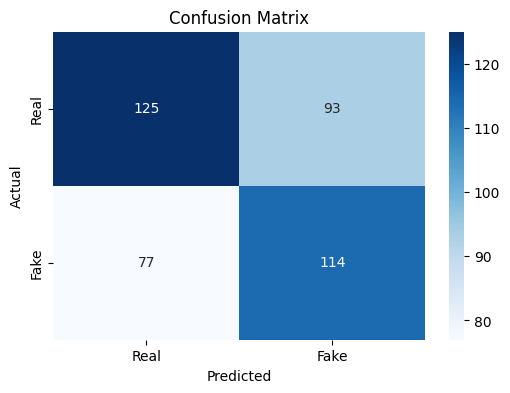

              precision    recall  f1-score   support

        Real       0.62      0.57      0.60       218
        Fake       0.55      0.60      0.57       191

    accuracy                           0.58       409
   macro avg       0.58      0.59      0.58       409
weighted avg       0.59      0.58      0.58       409



In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define Constants
IMG_SIZE = (128, 128)  # Adjust image size

# Step 1: Load images from local folders
def load_images_from_folder(folder, label, img_size=IMG_SIZE):
    images, labels = [], []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Step 2: Define paths
real_image_folder = 'D:\\detection model\\IMAGE\\real-and-fake-face-detection\\real_and_fake_face\\training_real'
fake_image_folder = 'D:\\detection model\\IMAGE\\real-and-fake-face-detection\\real_and_fake_face\\training_fake'

# Step 3: Load and preprocess images
real_images, real_labels = load_images_from_folder(real_image_folder, label=0)
fake_images, fake_labels = load_images_from_folder(fake_image_folder, label=1)
X = np.concatenate((real_images, fake_images), axis=0) / 255.0  # Normalize
y = np.concatenate((real_labels, fake_labels), axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define and Compile CNN Model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
model = create_cnn_model(input_shape)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True)
model.fit(datagen.flow(X_train, y_train, batch_size=20), epochs=10, validation_data=(X_test, y_test))

# Step 5: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Confusion Matrix and Classification Report
y_pred_classes = (model.predict(X_test) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred_classes, target_names=["Real", "Fake"]))

# Step 6: Predict on New Image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return "FAKE" if prediction[0][0] > 0.5 else "REAL"




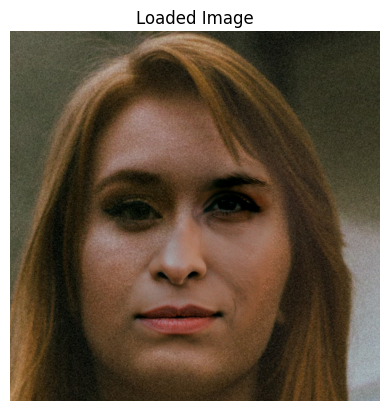

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
The image is REAL


In [2]:


# Display an example image
image_path = 'D:\\detection model\\IMAGE\\real-and-fake-face-detection\\real_and_fake_face\\training_fake\\easy_19_0111.jpg'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title("Loaded Image")
plt.show()
print(f"The image is {predict_image(image_path)}")

In [3]:
model.save("deepfake_image.h5")